Część 1

Wykonaj wykresy pudełkowe (ang.box plot), które pozwolą na graficzną identyfikację wartości odstających poprzez przedstawienie kwartyli i wartości skrajnych w danych dotyczących:

In [167]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes



In [168]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [169]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(population) AS `population`, 
    AVG(gdp_usd) AS `GDP`, 
    AVG(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_2_ex.csv', index=False)

merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

c:\Users\Cente\Desktop\studia\6 semestr studiow\bigdata\BigData\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


1.1. liczby nowych zachorowań
1.2. liczby nowych śmierci
1.3. liczby nowych szczepień

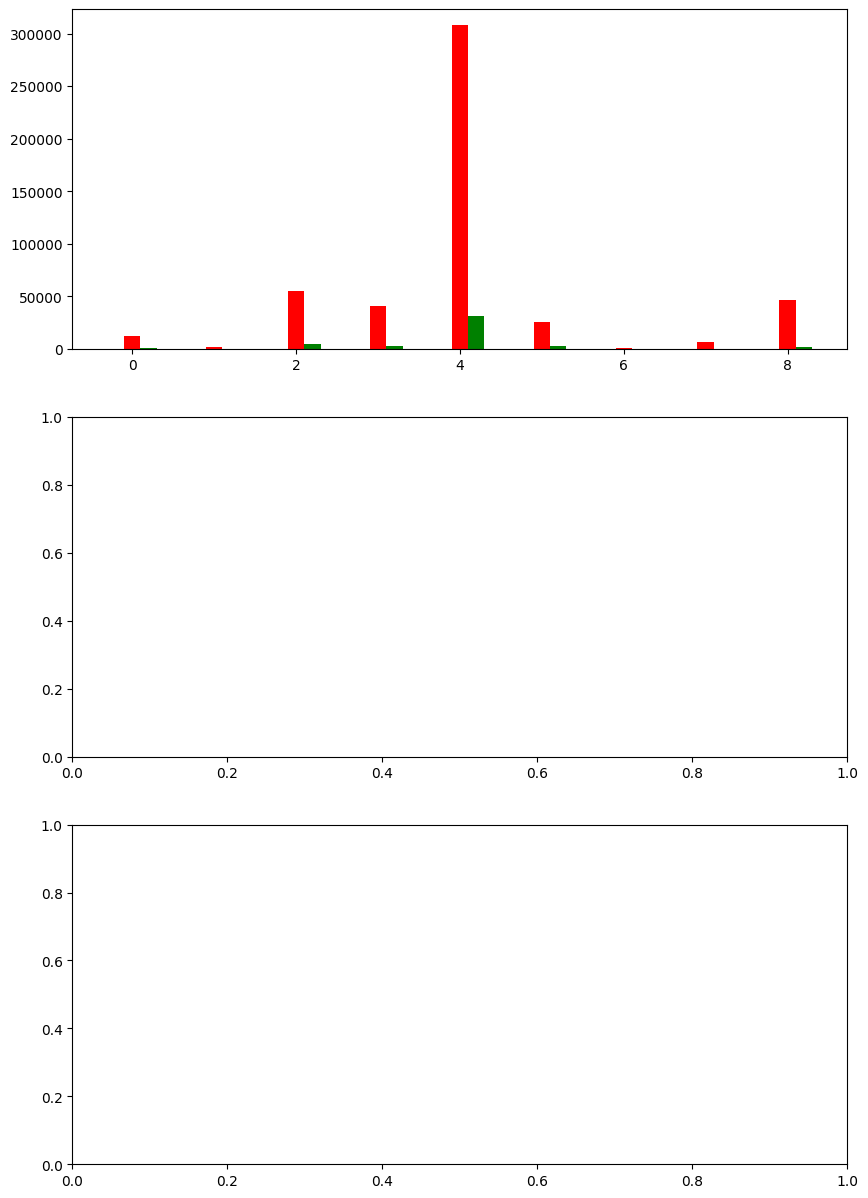

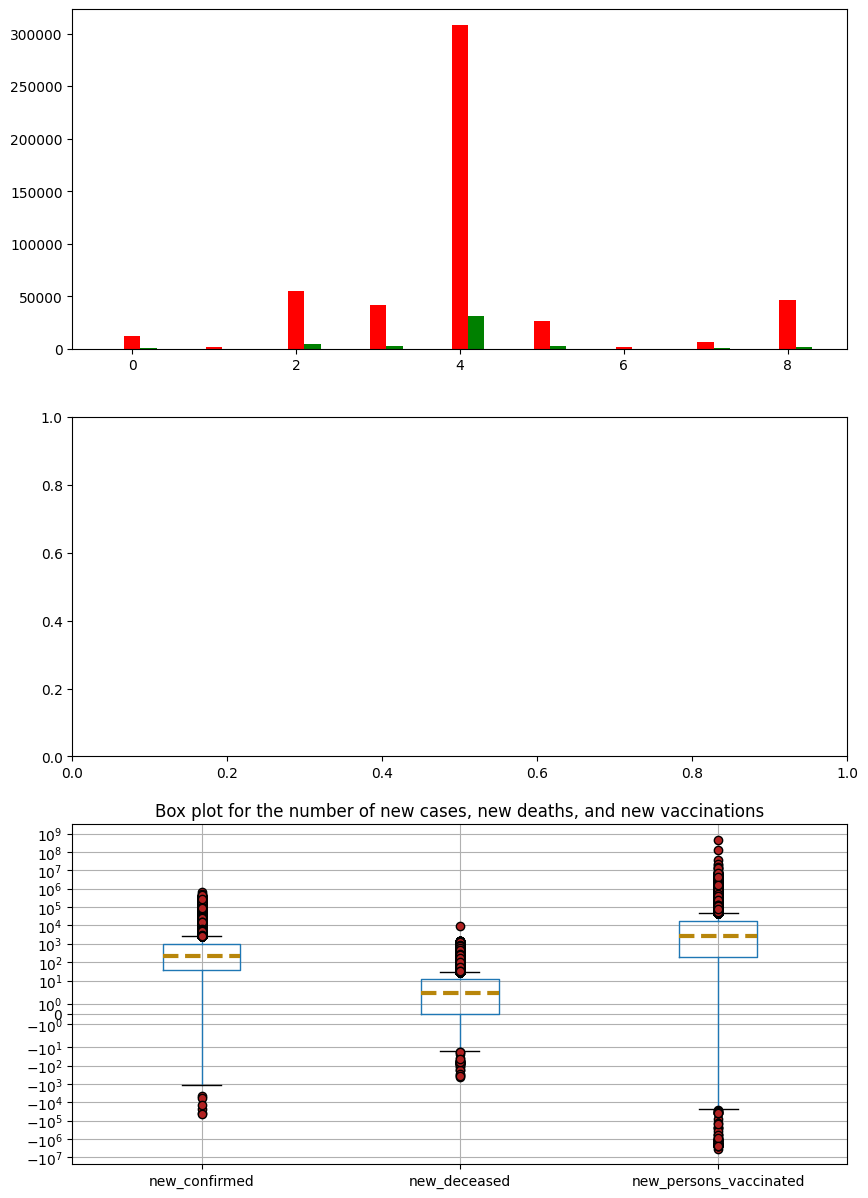

In [170]:
merged_data_df.boxplot(["new_confirmed", "new_deceased", "new_persons_vaccinated"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of new cases, new deaths, and new vaccinations')
plt.show()

1.4 Populacji

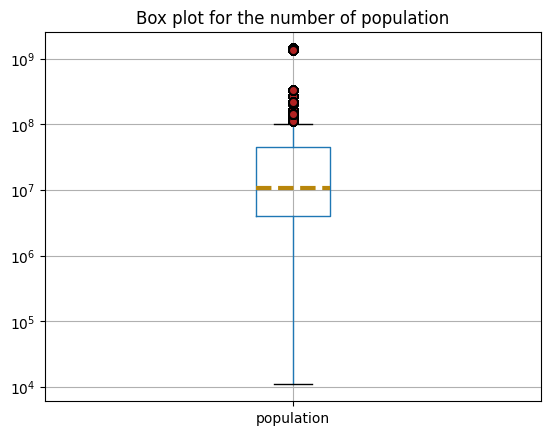

In [171]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

merged_data_df.boxplot(["population"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of population')
plt.show()

1.5 PKB

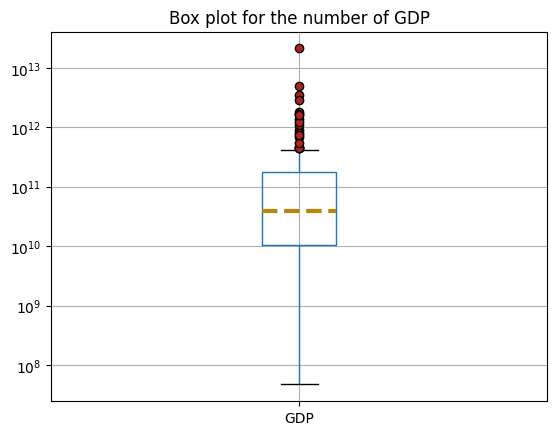

In [172]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_data_df = merged_data_df.drop_duplicates(subset="country_name")
merged_data_df.boxplot(["GDP"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of GDP')
plt.show()

1.6 -> 4 innych różnych informacji, które uznasz za istotne.

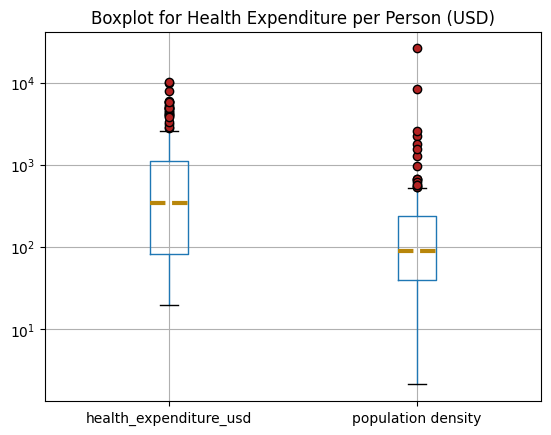

In [173]:
merged_data_df.boxplot(["health_expenditure_usd", "population density"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Boxplot for Health Expenditure per Person (USD)')
plt.show()

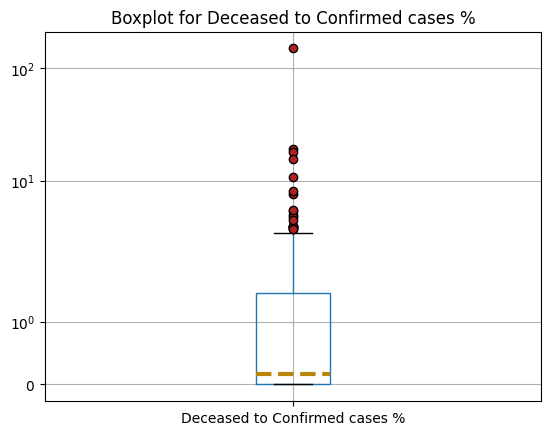

In [174]:
merged_data_df.boxplot(["Deceased to Confirmed cases %"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})

plt.yscale('symlog')
plt.title('Boxplot for Deceased to Confirmed cases %')
plt.show()

Część 3

Obliczenia statystyczne (m.in. średnia, mediana, moda, odchylenie standardowe) pozwolają na zrozumienie rozkładu danych oraz na identyfikację ewentualnych anomalii lub nietypowych wartości. 
Wykonaj następujące obliczenia:


3.1. średnia liczba nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu,

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


countries = ['Malta', 'Czech Republic', 'Ireland', 'Czech Republic', 'Poland', 'France', 'Norway', 'Germany', 'Denmark', 'Belgium']


merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
df_filtered = merged_covid_df[(merged_covid_df['date'].dt.year == 2021) & (merged_covid_df['date'].dt.month == 10) & (merged_covid_df['country_name'].isin(countries))]

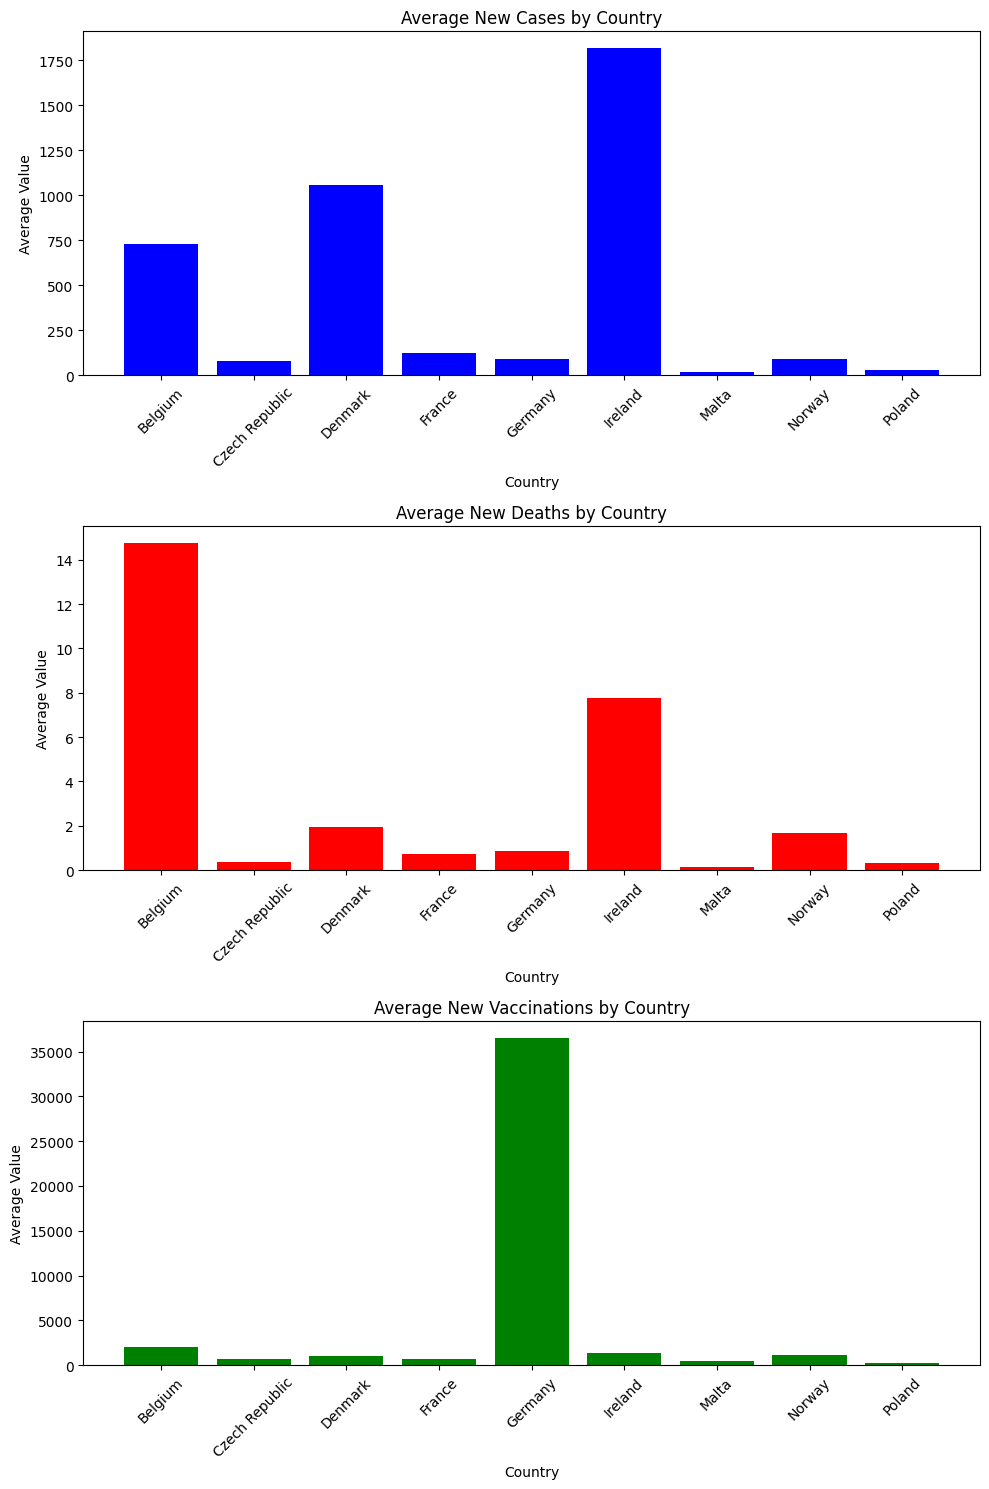

In [176]:
avg_values = df_filtered.groupby(['country_name']).agg({'new_confirmed': 'mean', 'new_deceased': 'mean', 'new_persons_vaccinated': 'mean'})
avg_values.reset_index(inplace=True)

index = np.arange(len(avg_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, avg_values['new_confirmed'], color='blue', label='New cases')
ax[0].set_title('Average New Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Average Value')
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_values['country_name'], rotation=45)

ax[1].bar(index, avg_values['new_deceased'], color='red', label='New deaths')
ax[1].set_title('Average New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Average Value')
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_values['country_name'], rotation=45)

ax[2].bar(index, avg_values['new_persons_vaccinated'], color='green', label='New vaccinations')
ax[2].set_title('Average New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Average Value')
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()


3.2. średnia zmiana liczby zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu

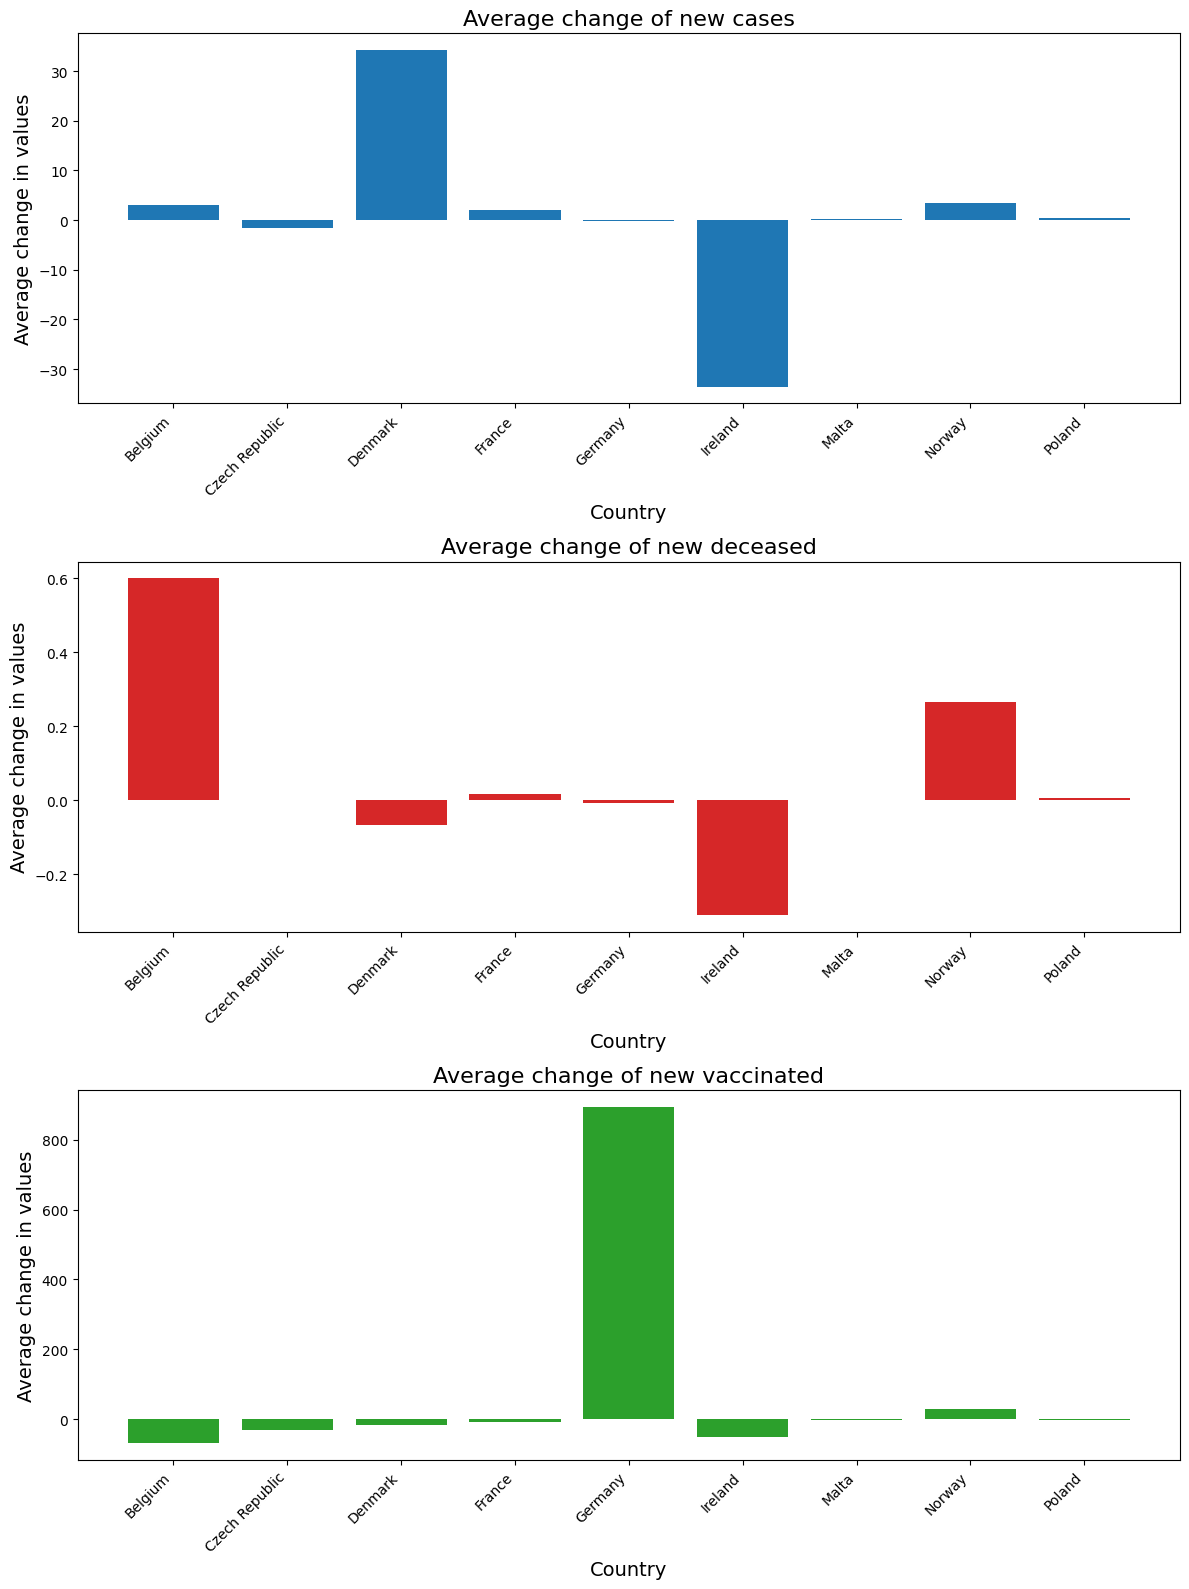

In [177]:

import matplotlib.pyplot as plt
import numpy as np

avg_diff_values = df_filtered.groupby('country_name')[['new_confirmed', 'new_deceased', 'new_persons_vaccinated']].diff()
avg_diff_values = avg_diff_values.groupby(df_filtered['country_name']).mean()
avg_diff_values.reset_index(inplace=True)

index = np.arange(len(avg_diff_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(12, 16))

ax[0].bar(index, avg_diff_values['new_confirmed'], color='#1f77b4')
ax[0].set_title('Average change of new cases', fontsize=16)
ax[0].set_xlabel('Country', fontsize=14)
ax[0].set_ylabel('Average change in values', fontsize=14)
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[1].bar(index, avg_diff_values['new_deceased'], color='#d62728')
ax[1].set_title('Average change of new deceased', fontsize=16)
ax[1].set_xlabel('Country', fontsize=14)
ax[1].set_ylabel('Average change in values', fontsize=14)
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[2].bar(index, avg_diff_values['new_persons_vaccinated'], color='#2ca02c')
ax[2].set_title('Average change of new vaccinated', fontsize=16)
ax[2].set_xlabel('Country', fontsize=14)
ax[2].set_ylabel('Average change in values', fontsize=14)
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


 3.3. mediana liczby nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu, 

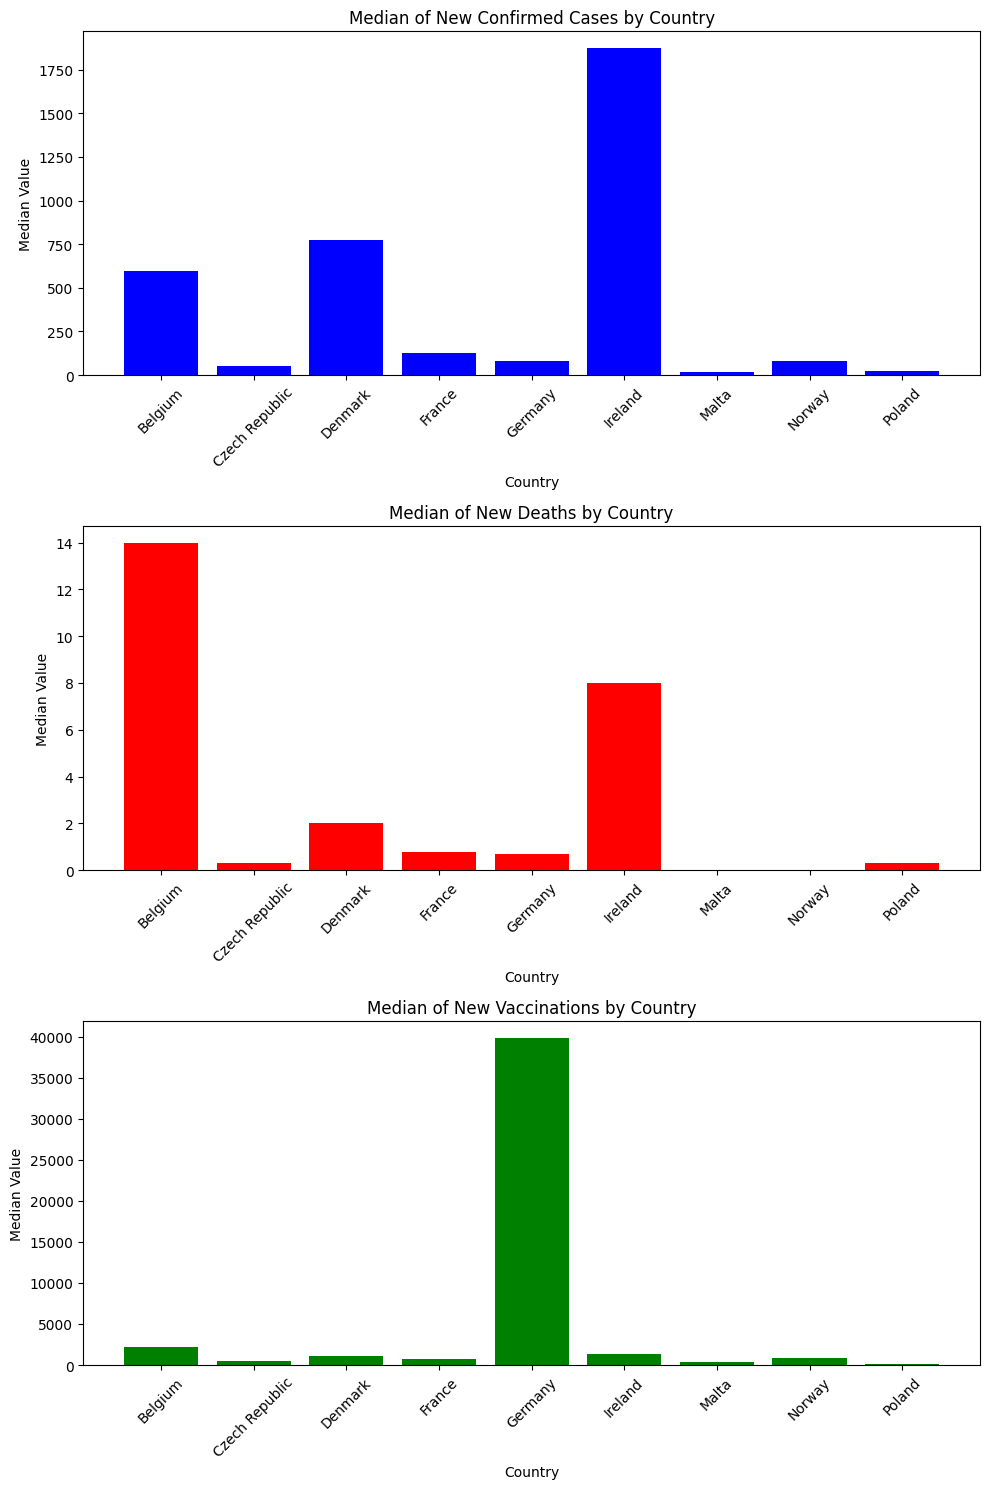

In [178]:
median_values = df_filtered.groupby(['country_name']).agg({'new_confirmed': 'median', 'new_deceased': 'median', 'new_persons_vaccinated': 'median'})
median_values.reset_index(inplace=True)

index = np.arange(len(median_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, median_values['new_confirmed'], color='blue')
ax[0].set_title('Median of New Confirmed Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Median Value')
ax[0].set_xticks(index)
ax[0].set_xticklabels(median_values['country_name'], rotation=45)

ax[1].bar(index, median_values['new_deceased'], color='red')
ax[1].set_title('Median of New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Median Value')
ax[1].set_xticks(index)
ax[1].set_xticklabels(median_values['country_name'], rotation=45)

ax[2].bar(index, median_values['new_persons_vaccinated'], color='green')
ax[2].set_title('Median of New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Median Value')
ax[2].set_xticks(index)
ax[2].set_xticklabels(median_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()


3.4. odchylenie standardowe liczby nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu,

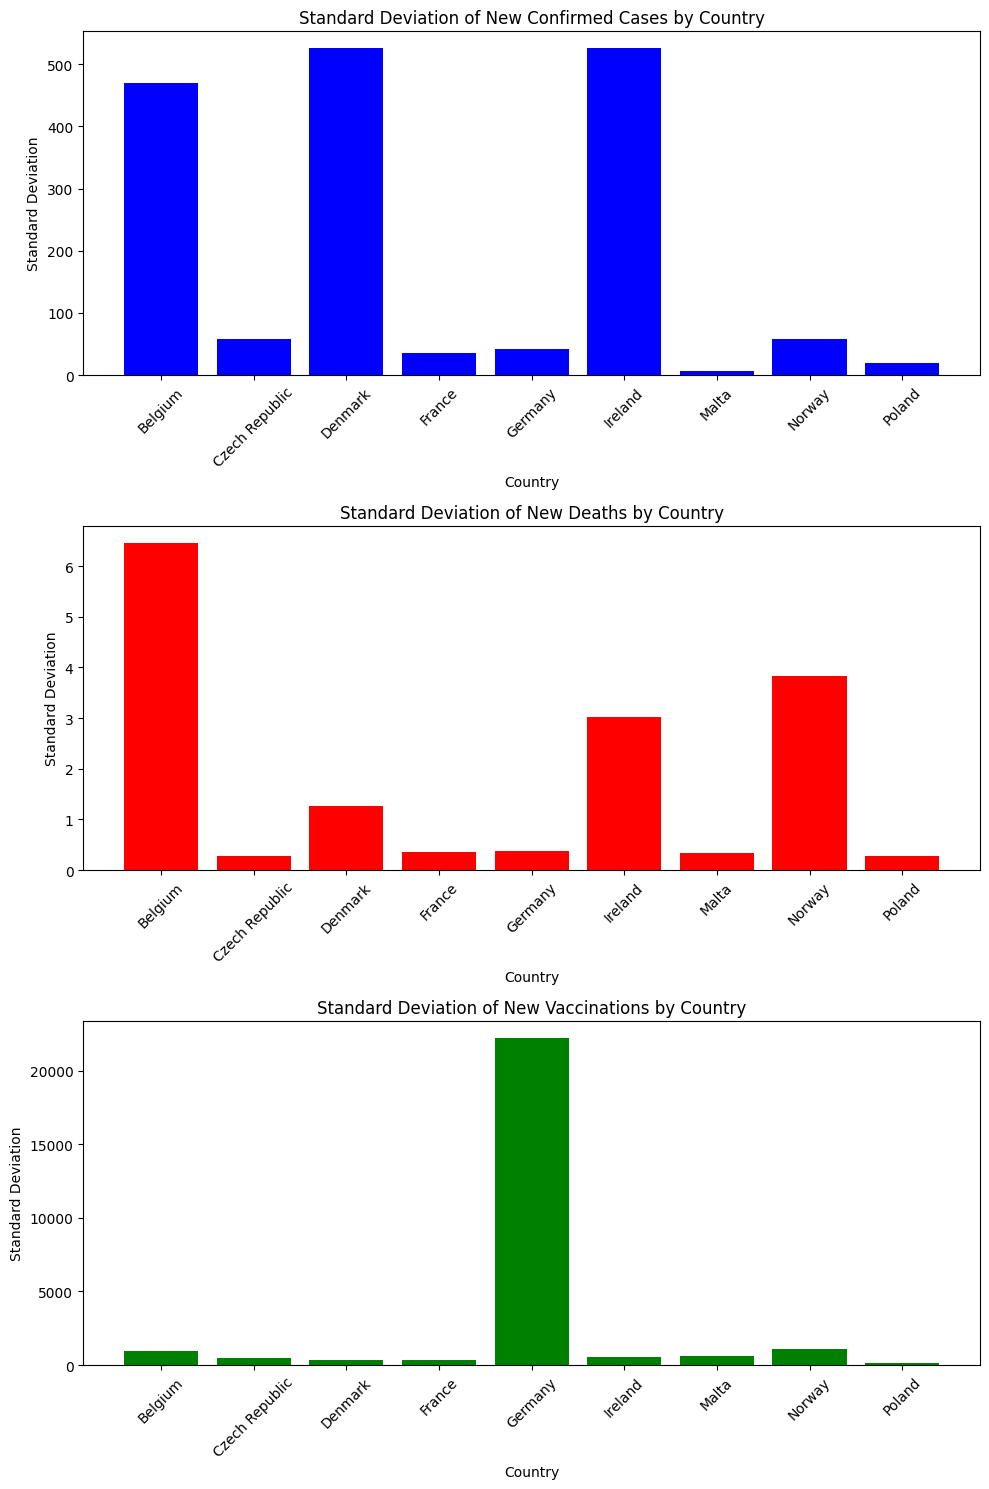

In [179]:
std_values = df_filtered.groupby(['country_name']).agg({'new_confirmed': 'std', 'new_deceased': 'std', 'new_persons_vaccinated': 'std'})
std_values.reset_index(inplace=True)

index = np.arange(len(std_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, std_values['new_confirmed'], color='blue')
ax[0].set_title('Standard Deviation of New Confirmed Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Standard Deviation')
ax[0].set_xticks(index)
ax[0].set_xticklabels(std_values['country_name'], rotation=45)

ax[1].bar(index, std_values['new_deceased'], color='red')
ax[1].set_title('Standard Deviation of New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_xticks(index)
ax[1].set_xticklabels(std_values['country_name'], rotation=45)

ax[2].bar(index, std_values['new_persons_vaccinated'], color='green')
ax[2].set_title('Standard Deviation of New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Standard Deviation')
ax[2].set_xticks(index)
ax[2].set_xticklabels(std_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()


Przygotowanie danych dla 3.5 oraz 3.6

In [207]:
merged_country_df = pd.read_csv('results\\prepared_for_2_ex.csv')
countries_df = merged_country_df[(merged_country_df['country_name'].isin(countries))]


min_values = countries_df.groupby(['country_name']).agg({'new_confirmed': 'min', 'new_deceased': 'min', 'new_persons_vaccinated': 'min', 'GDP' : 'mean', 'population' : 'mean'})
min_values.reset_index(inplace=True)

max_values = countries_df.groupby(['country_name']).agg({'new_confirmed': 'max', 'new_deceased': 'max', 'new_persons_vaccinated': 'max', 'GDP' : 'mean', 'population' : 'mean'})
max_values.reset_index(inplace=True)

avg_values = countries_df.groupby(['country_name']).agg({'new_confirmed': 'mean', 'new_deceased': 'mean', 'new_persons_vaccinated': 'mean', 'GDP' : 'mean', 'population' : 'mean'})
avg_values.reset_index(inplace=True)


index = np.arange(len(min_values['country_name']))

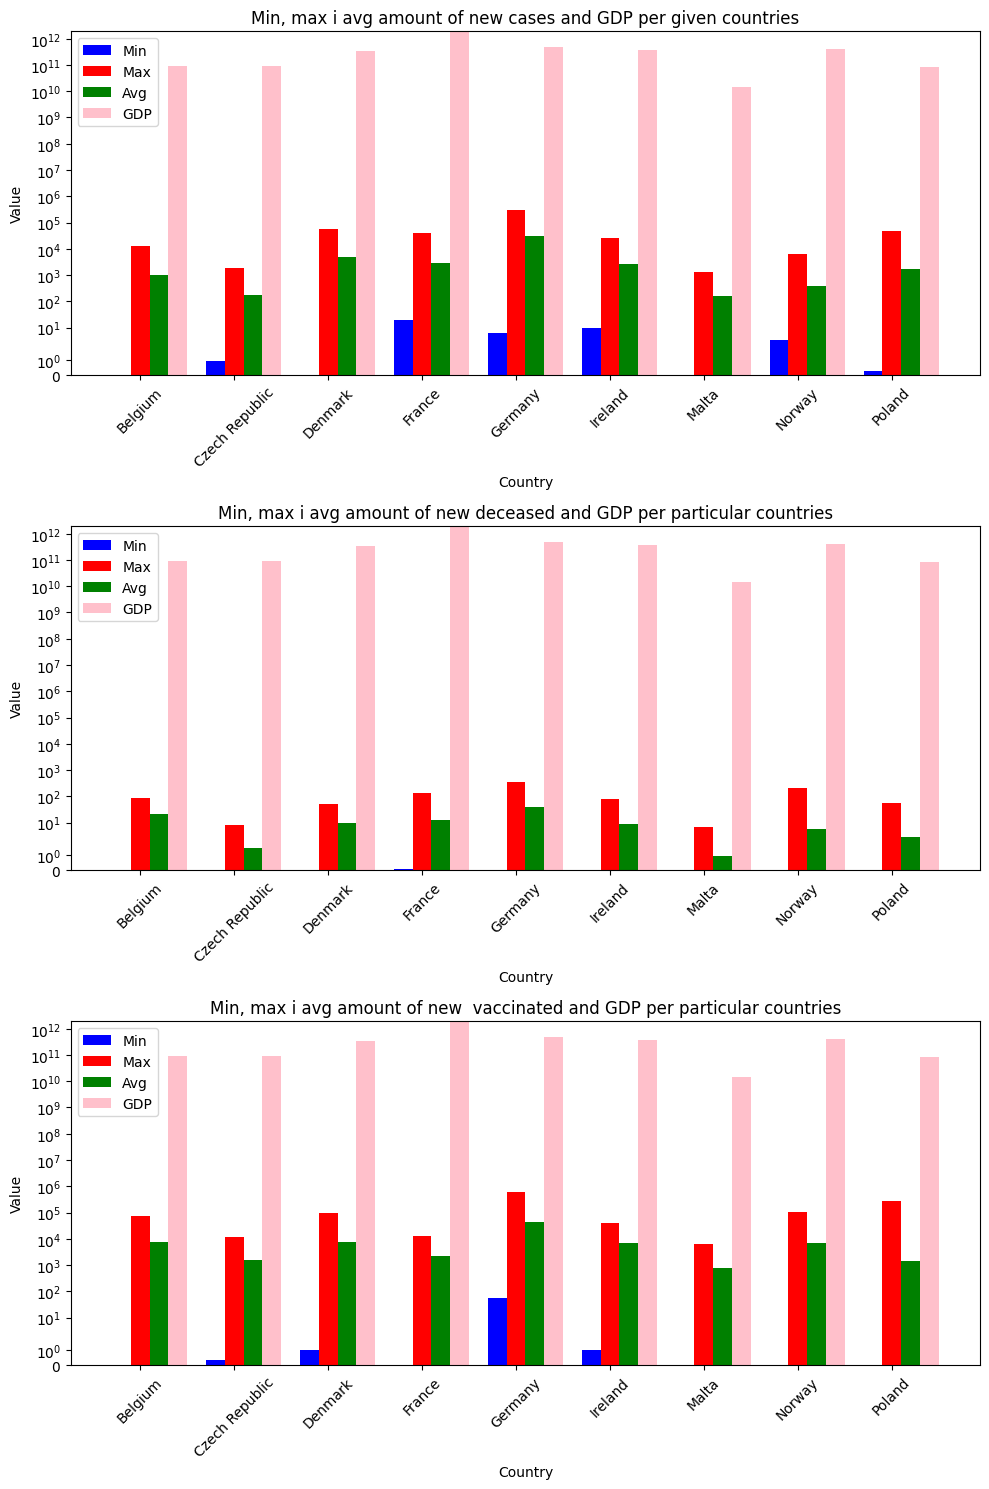

In [208]:
bar_width = 0.2

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(index - bar_width, min_values['new_confirmed'], bar_width, color='blue', label='Min')
ax[0].bar(index, max_values['new_confirmed'], bar_width, color='red', label='Max')
ax[0].bar(index + bar_width, avg_values['new_confirmed'], bar_width, color='green', label='Avg')
ax[0].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink', label='GDP')

ax[1].bar(index - bar_width, min_values['new_deceased'], bar_width, color='blue', label='Min')
ax[1].bar(index, max_values['new_deceased'], bar_width, color='red', label='Max')
ax[1].bar(index + bar_width, avg_values['new_deceased'], bar_width, color='green', label='Avg')
ax[1].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink', label='GDP')


ax[2].bar(index - bar_width, min_values['new_persons_vaccinated'], bar_width, color='blue', label='Min')
ax[2].bar(index, max_values['new_persons_vaccinated'], bar_width, color='red', label='Max')
ax[2].bar(index + bar_width, avg_values['new_persons_vaccinated'], bar_width, color='green', label='Avg')
ax[2].bar(index + 2 * bar_width, avg_values['GDP'], bar_width, color='pink', label='GDP')

for ax_i in ax:
    ax_i.set_xlabel('Country')
    ax_i.set_ylabel('Value')
    ax_i.set_xticks(index)
    ax_i.set_xticklabels(min_values['country_name'], rotation=45)
    ax_i.legend()
    ax_i.set_yscale('symlog')

ax[0].set_title('Min, max i avg amount of new cases and GDP per given countries')
ax[1].set_title('Min, max i avg amount of new deceased and GDP per particular countries')
ax[2].set_title('Min, max i avg amount of new  vaccinated and GDP per particular countries')

plt.tight_layout()
plt.show()

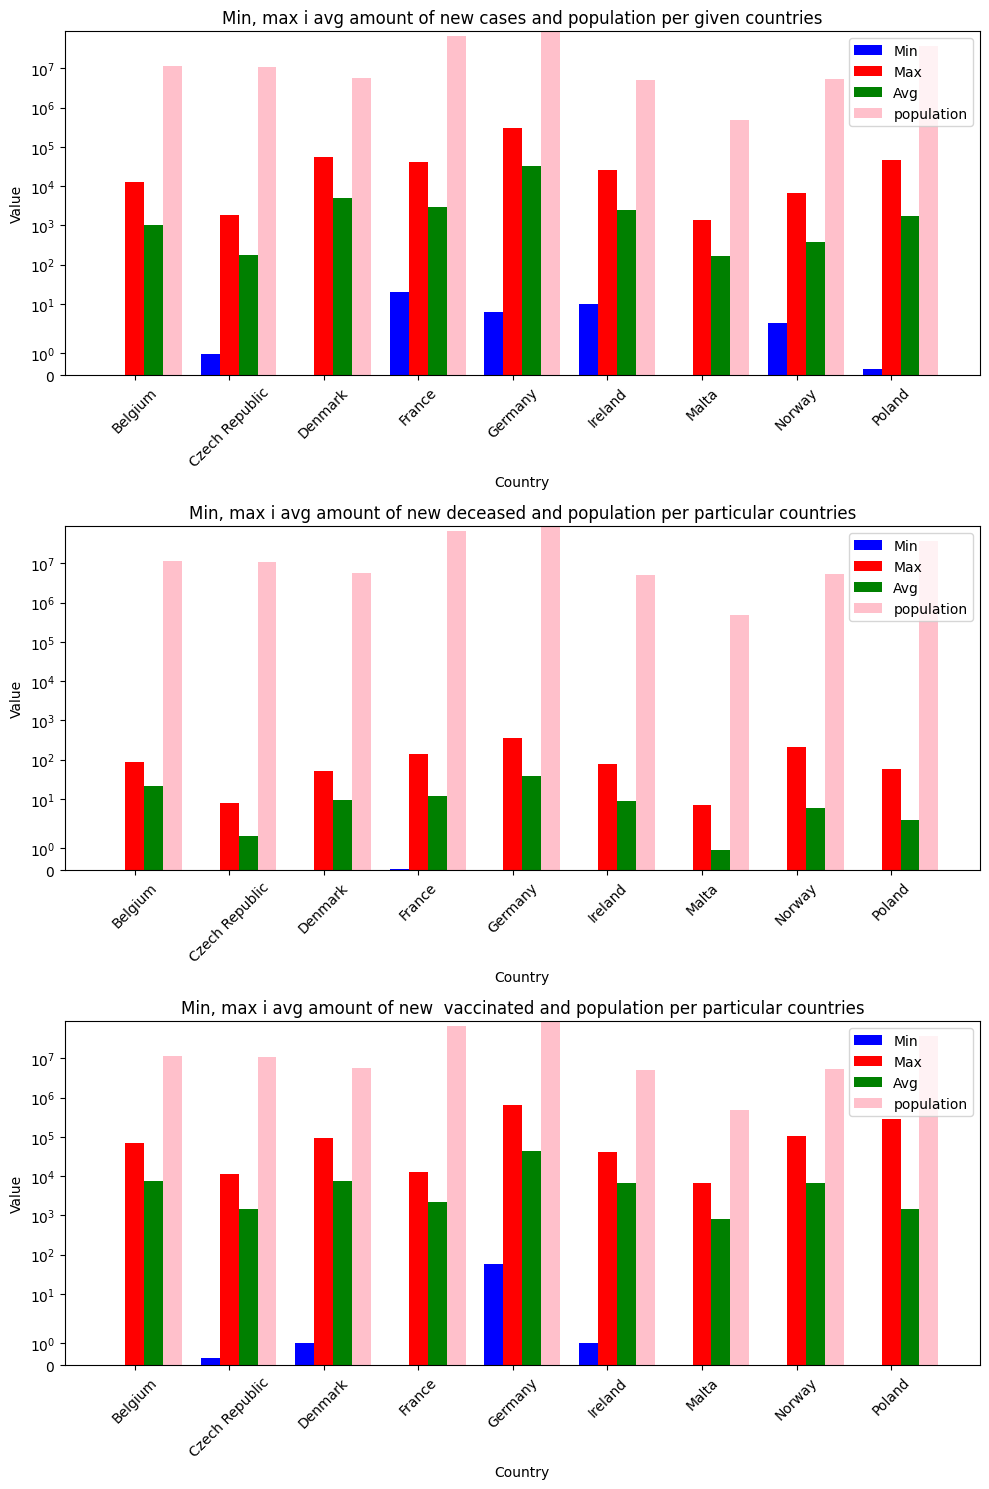

In [209]:
bar_width = 0.2

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(index - bar_width, min_values['new_confirmed'], bar_width, color='blue', label='Min')
ax[0].bar(index, max_values['new_confirmed'], bar_width, color='red', label='Max')
ax[0].bar(index + bar_width, avg_values['new_confirmed'], bar_width, color='green', label='Avg')
ax[0].bar(index + 2 * bar_width, avg_values['population'], bar_width, color='pink', label='population')

ax[1].bar(index - bar_width, min_values['new_deceased'], bar_width, color='blue', label='Min')
ax[1].bar(index, max_values['new_deceased'], bar_width, color='red', label='Max')
ax[1].bar(index + bar_width, avg_values['new_deceased'], bar_width, color='green', label='Avg')
ax[1].bar(index + 2 * bar_width, avg_values['population'], bar_width, color='pink', label='population')


ax[2].bar(index - bar_width, min_values['new_persons_vaccinated'], bar_width, color='blue', label='Min')
ax[2].bar(index, max_values['new_persons_vaccinated'], bar_width, color='red', label='Max')
ax[2].bar(index + bar_width, avg_values['new_persons_vaccinated'], bar_width, color='green', label='Avg')
ax[2].bar(index + 2 * bar_width, avg_values['population'], bar_width, color='pink', label='population')

for ax_i in ax:
    ax_i.set_xlabel('Country')
    ax_i.set_ylabel('Value')
    ax_i.set_xticks(index)
    ax_i.set_xticklabels(min_values['country_name'], rotation=45)
    ax_i.legend()
    ax_i.set_yscale('symlog')

ax[0].set_title('Min, max i avg amount of new cases and population per given countries')
ax[1].set_title('Min, max i avg amount of new deceased and population per particular countries')
ax[2].set_title('Min, max i avg amount of new  vaccinated and population per particular countries')

plt.tight_layout()
plt.show()